# Forecasting the Price & Trend of CAD-USD Exchange based on historical Data 

In the previous notebook ("CAD-USD Price - Part 1 - Analysis"), I cleaned & analysed historic data (Nov 21, 2017 to Nov 21, 2022) on CAD-USD price. The analysis involved ETS Decomposition as well as Holt-Winters methods to identify if there is any Trend or seasonality in the data.

In this section, I will use the same dataset to predict future prices using a variety of Forecasting Models. At the end, the performance of each of the models will be evaluated. 

### Goal

Since I am dealing with exchange prices, this can be very tricky to predict as it's dependent on several other factors apart from time. 
So I will attempt the forecast the price & the future trend 

### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates 
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Dataset

I will use the data on daily CAD/USD conversion rates from November 21, 2017 - November 21, 2022 from Yahoo finance


In [660]:
data = pd.read_csv(r'C:\Users\olalawal\Downloads\CADUSD.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-22,0.782963,0.786411,0.782791,0.782840,0.782840,0.0
1,2017-11-23,0.786999,0.789204,0.785960,0.787092,0.787092,0.0
2,2017-11-24,0.786596,0.787836,0.784560,0.786621,0.786621,0.0
3,2017-11-27,0.786559,0.788706,0.784252,0.786535,0.786535,0.0
4,2017-11-28,0.783816,0.784191,0.779818,0.783797,0.783797,0.0


### Data Cleaning

From the analysis in Part 1, we already discovered there were some unwanted columns & NAN entries, so we will remove them

In [661]:
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', drop=True, inplace=True)
# We will use a business day frequency since we only have prices from Monday to Friday
data.index.freq='B'
data.index

DatetimeIndex(['2017-11-22', '2017-11-23', '2017-11-24', '2017-11-27',
               '2017-11-28', '2017-11-29', '2017-11-30', '2017-12-01',
               '2017-12-04', '2017-12-05',
               ...
               '2022-11-09', '2022-11-10', '2022-11-11', '2022-11-14',
               '2022-11-15', '2022-11-16', '2022-11-17', '2022-11-18',
               '2022-11-21', '2022-11-22'],
              dtype='datetime64[ns]', name='Date', length=1305, freq='B')

In [662]:
data.drop(labels=['Adj Close', 'Volume'], axis = 1, inplace=True)
data.dropna(axis =0, how = 'any', inplace=True)
data.shape

(1304, 4)

In [663]:
data.index

DatetimeIndex(['2017-11-22', '2017-11-23', '2017-11-24', '2017-11-27',
               '2017-11-28', '2017-11-29', '2017-11-30', '2017-12-01',
               '2017-12-04', '2017-12-05',
               ...
               '2022-11-09', '2022-11-10', '2022-11-11', '2022-11-14',
               '2022-11-15', '2022-11-16', '2022-11-17', '2022-11-18',
               '2022-11-21', '2022-11-22'],
              dtype='datetime64[ns]', name='Date', length=1304, freq=None)

In [664]:
#The freq has been reverted to None. Dont know how to deal with this 
data.index=data.index.to_period('B')

In [665]:
data.index

PeriodIndex(['2017-11-22', '2017-11-23', '2017-11-24', '2017-11-27',
             '2017-11-28', '2017-11-29', '2017-11-30', '2017-12-01',
             '2017-12-04', '2017-12-05',
             ...
             '2022-11-09', '2022-11-10', '2022-11-11', '2022-11-14',
             '2022-11-15', '2022-11-16', '2022-11-17', '2022-11-18',
             '2022-11-21', '2022-11-22'],
            dtype='period[B]', name='Date', length=1304)

### Train/Test Split

I want the model to be able to forecast prices within 6 months into the future, so my test set should have data for at least 6 months after the train set.
so for the train set: I will select approximately the last 9 months in the dataset (20 business days in a month for 9 months is 180)

In [666]:
train_set = data[:1124]
test_set = data[1124:]
test_set.index.freq 

<BusinessDay>

### Implementing different Models

### Model 1 - Holt-Winters Triple Exponential Smoothing 

The Holt-Winters Triple ES can be used to model data that has both trends & seasonality

From the analysis in part 1, I saw that the data has trends and a little bit of seasonality (although, not a lot)

After carefully analysing the seasonality plot from the ETS decomposition, I'll say the data has some monthly seasonality

However I will use 3 different values for seasonal periods:
- 5 business days for weekly cycle
- 20 business days in a monthly cycle
- 260 for year

In [667]:
#Using a seasonal period of 260 (5 business days in a week & 52 weeks in a year)


fitted_model_weekly = ExponentialSmoothing(train_set['Close'], trend ='add', seasonal = 'add', seasonal_periods=5).fit()
fitted_model_monthly = ExponentialSmoothing(train_set['Close'], trend ='add', seasonal = 'add', seasonal_periods=20).fit()
fitted_model_annual = ExponentialSmoothing(train_set['Close'], trend ='add', seasonal = 'add', seasonal_periods=260).fit()
predicted_prices_week = fitted_model_weekly.forecast(180) #Using 180 because thats the amount of data points that we want to forecast (just like the data set )
predicted_prices_month = fitted_model_monthly.forecast(180)
predicted_prices_annual = fitted_model_annual.forecast(180)

#### Evaluating Model 1 - Holt-Winters Triple Exponential Smoothing 

Now let's see how the model performed by plotting the result & calculating the RMSE for each model 

<AxesSubplot:xlabel='Date'>

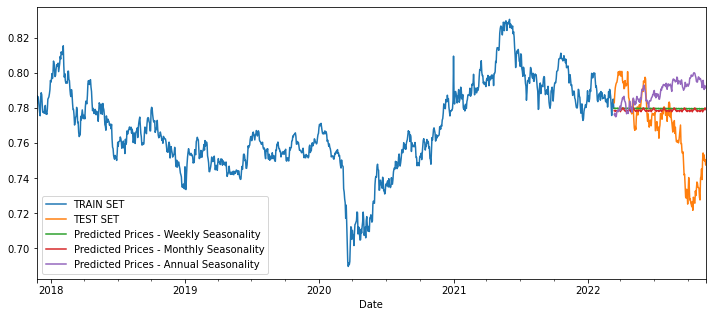

In [668]:
train_set['Close'].plot(legend = True, label = 'TRAIN SET', figsize = (12,5))
test_set['Close'].plot(legend = True, label = 'TEST SET')
predicted_prices_week.plot(legend = True, label = 'Predicted Prices - Weekly Seasonality')
predicted_prices_month.plot(legend = True, label = 'Predicted Prices - Monthly Seasonality')
predicted_prices_annual.plot(legend = True, label = 'Predicted Prices - Annual Seasonality')

<AxesSubplot:xlabel='Date'>

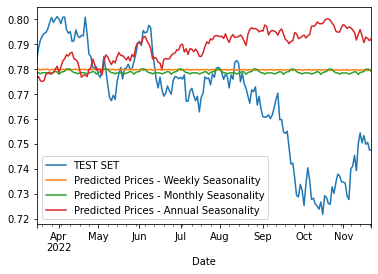

In [669]:
test_set['Close'].plot(legend = True, label = 'TEST SET')
predicted_prices_week.plot(legend = True, label = 'Predicted Prices - Weekly Seasonality')
predicted_prices_month.plot(legend = True, label = 'Predicted Prices - Monthly Seasonality')
predicted_prices_annual.plot(legend = True, label = 'Predicted Prices - Annual Seasonality')

### Evaluate Model 1- Holt-Winters ET model

### Calculate RMSE 

In [670]:
#The rmse for the weekly seasnonality model 
rmse_weekly = mean_squared_error(test_set['Close'],predicted_prices_week, squared=False )

#The rmse for the monthly seasonality model 
rmse_monthly = mean_squared_error(test_set['Close'],predicted_prices_month, squared=False )

#The rmse for the annual seasonality model 
rmse_annual = mean_squared_error(test_set['Close'],predicted_prices_annual, squared=False )

print(f'The RMSE for the Holt-Winters ET model with weekly seasonality is {rmse_weekly}')
print(f'The RMSE for the Holt-Winters ET model with monthly seasonality is {rmse_monthly}')
print(f'The RMSE for the Holt-Winters ET model with weekly seasonality is {rmse_annual}')

The RMSE for the Holt-Winters ET model with weekly seasonality is 0.024502088350959086
The RMSE for the Holt-Winters ET model with monthly seasonality is 0.02410175027437978
The RMSE for the Holt-Winters ET model with weekly seasonality is 0.03380904834072822


In [671]:
test_set['Close'].describe()

count    180.000000
mean       0.768410
std        0.021806
min        0.721761
25%        0.754429
50%        0.773500
75%        0.782154
max        0.801134
Name: Close, dtype: float64

### How did the Models perform?

**Which seasonality period gave the best performance?**
   - The model with the monthly seasonality period gave the best performance, This is not surprising as the ETS decomposition already gave an idea that there is a bit of monthly seasonality in the data

**Is the RMSE good or bad?**
  - The relative RMSE (RMSE/mean of the dataset) = 0.031 (about 3%)
  - The RMSE is greater than the SD of the dataset
  
 My conclusion is that the RMSE is not so good 

**Was the model able to predict the future trend? i.e prices stable, increasing or decreasing**
   - The three models were not able to correctly predict the future trends. Infact two of the models predicted the prices being relatively stable for the period and we can see that was not the case 

### Conclusion & Recommendation

This Holt-Winters ET model didnt correctly predict the price or the future trend. This could be because this kind of data (CAD/USD exhange prices) depends on a lot more factors rather than the time stamp.
I'll try other models to see if they will give better performance

#### Model 2 - Auto Regression Model

AR - Just like regression but the parameters is the time series data with lags. 
So parameter one can be the time series itself with one lag backwards.
The order of the AR model is the no of lags used. So in the example above, the order is 1.
The more order you use, the better performance but it will reach a stage when performance starts to decline. So this is why you need to select the optimal order to use.

In [672]:
from statsmodels.tsa.ar_model import AutoReg,ARResults

<AxesSubplot:xlabel='Date'>

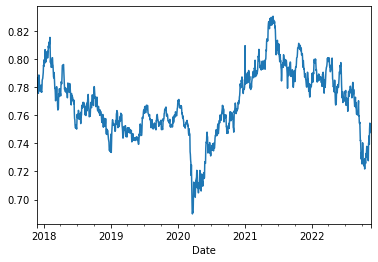

In [673]:
data['Close'].plot()

Seeing the way my data is right now, AR model will most likely not perform well since there isnt a clear linearity. But let me find out!

In [674]:
import warnings
warnings.filterwarnings('ignore')

### Training a 1st order AR model

In [675]:
AR_Order1 = AutoReg(train_set['Close'], lags=1).fit()

In [676]:
start = len(train_set['Close']) + 1

In [677]:
end = len(train_set['Close']) + len(test_set['Close'])

In [678]:
predictions1 = AR_Order1.predict(start = start, end = end).rename('AR(1) Predictions')

In [679]:
predictions1


2022-03-16    0.779753
2022-03-17    0.779649
2022-03-18    0.779545
2022-03-21    0.779443
2022-03-22    0.779342
                ...   
2022-11-16    0.770777
2022-11-17    0.770756
2022-11-18    0.770737
2022-11-21    0.770717
2022-11-22    0.770697
Freq: B, Name: AR(1) Predictions, Length: 180, dtype: float64

In [680]:
AR_Order2 = AutoReg(train_set['Close'], lags=2).fit()

In [681]:
predictions2 = AR_Order2.predict(start = start, end = end).rename('AR(2) Predictions')

### Evaluating Model 2 - AutoRegression Model

<AxesSubplot:xlabel='Date'>

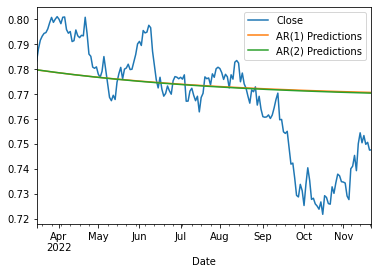

In [682]:
test_set['Close'].plot(legend = True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)

### Calculate the RMSE

In [683]:
rmse_lag1 = mean_squared_error(test_set['Close'],predictions1, squared=False)
rmse_lag2 = mean_squared_error(test_set['Close'],predictions2, squared=False)
print(f'RMSE for first order AR model is {rmse_lag1}')
print(f'RMSE for second order AR model is {rmse_lag2}')

RMSE for first order AR model is 0.0204744407499538
RMSE for second order AR model is 0.020361060586043315


### How did the AR Models perform?

**Which lag gave the best performance?**
   - The second order AR model gave a slightly lower RMSE than the other model.

**How do I select the best lag (order) to use for the AR model?**
  - Lets have statsmodels tell us the best order to use 

In [684]:
from statsmodels.tsa.ar_model import ar_select_order

In [685]:
select_order = ar_select_order(data['Close'], maxlag = 20, ic = 'aic')

In [686]:
select_order.ar_lags

[1, 2, 3]

Statsmodel says a lag of 1 is the optimal lag, even though lag 2 gave less rmse. This is probably because statsmodel uses aic to judge the best lag and this penalises more complex models. 

**Was the model able to predict the future trend?**

- In my opinion, This AR model did not give a good performance. 
- Even though the RMSE is lower than that of the Holt-Winters model, this AR model tries to plot a best fit line for the stock prices which is not appropriate for this kind of dataset because it doesnt have a linear relationship with time. 
- Hence, the model was not able to accurately forecast the future prices or trends
- Let's try more models

### Model 3 - AutoRegressive Integrated Moving Average (ARIMA)

From Analysis, I also confirmed that the data is not stationary, So I will need to transform it to be stationary in order to evaluate it & what type of parameters to use for ARIMA.

The Differencing technique can be used to transform the dataset to stationary. You may have to difference multiple times before finally reaching stationarity.

Pyramid arima is a library that can be used to do a grid search for p,d,q and it will also tell you whether to use a seasonal arima model (by giving P,D,Q).
It uses the AIC metric to decide on the optimal p,d,q for you.

In [687]:
from pmdarima import auto_arima

In [688]:
grid_search = auto_arima(data['Close'], start_p = 0, start_q = 0, max_q = 4, max_p = 6, trace = True, seasonal = True) #you can use the entire data


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11031.002, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11029.464, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11029.551, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11032.924, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11028.173, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.398 seconds


In [689]:
grid_search.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1304
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5517.462
Date:                Wed, 30 Nov 2022   AIC                         -11032.924
Time:                        16:28:06   BIC                         -11027.752
Sample:                    11-22-2017   HQIC                        -11030.984
                         - 11-22-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.228e-05   2.71e-07     45.350      0.000    1.17e-05    1.28e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):              1006.89
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Pyramid Arima suggests:
- P = 0
- d = 1 - The data should be differenced 1 time
- q = 0

This is a random walk model (find out more)

In [690]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

In [691]:
arima_mod = ARIMA(train_set['Close'], order = (0,1,0)).fit()

In [692]:
predictions_arima = arima_mod.predict(start=start, end = end)

In [693]:
preditions_arima

2022-03-16    0.779964
2022-03-17    0.779964
2022-03-18    0.779964
2022-03-21    0.779964
2022-03-22    0.779964
                ...   
2022-11-16    0.779964
2022-11-17    0.779964
2022-11-18    0.779964
2022-11-21    0.779964
2022-11-22    0.779964
Freq: B, Name: predicted_mean, Length: 180, dtype: float64

### Evaluating Model 2 - ARIMA Model

<AxesSubplot:xlabel='Date'>

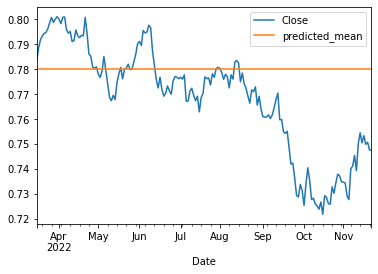

In [694]:
test_set['Close'].plot(legend = True)
preditions_arima.plot(legend=True)

In [562]:
from statsmodels.tools.eval_measures import rmse

In [563]:
rmse(preditions_arima,test_set['Close'])

0.024624180260693164

The ARIMA model tries to use the average of the past to predict the future stock prices. This is not such a good performance.

### Model 4 - Recurrent Neural Network

### Step 1 - Scale the Dataset

When working with neural networks, you need to scale the data so it all falls between 0 & 1

In [695]:
from sklearn.preprocessing import MinMaxScaler

In [696]:
scaler = MinMaxScaler()

In [697]:
scaler.fit(train_set[['Close']]) #Only fit on the training data
#This will find the max value in the training data

MinMaxScaler()

In [698]:
scaled_train = scaler.transform(train_set[['Close']])

In [699]:
scaled_test = scaler.transform(test_set[['Close']])

### Step 2 - Transofrm the data to this format; Input = [X1, x2, x3, ... Xn] Output = [Y]

In [700]:
#Use a time series generator for your dataset, to transform it to the way you want 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [701]:
train_generator = TimeseriesGenerator(scaled_train,scaled_train, length = 20, batch_size=1)

In [702]:
X,y = train_generator[0]

In [703]:
X,y

(array([[[0.66045459],
         [0.69061875],
         [0.68727742],
         [0.68666733],
         [0.66724365],
         [0.64281863],
         [0.62245853],
         [0.60988068],
         [0.68486542],
         [0.70294831],
         [0.69545693],
         [0.65485024],
         [0.62417531],
         [0.62331692],
         [0.62631773],
         [0.61989047],
         [0.6422582 ],
         [0.65155858],
         [0.61714505],
         [0.62121707]]]),
 array([[0.61552049]]))

In [704]:
train_generator[1]

(array([[[0.69061875],
         [0.68727742],
         [0.68666733],
         [0.66724365],
         [0.64281863],
         [0.62245853],
         [0.60988068],
         [0.68486542],
         [0.70294831],
         [0.69545693],
         [0.65485024],
         [0.62417531],
         [0.62331692],
         [0.62631773],
         [0.61989047],
         [0.6422582 ],
         [0.65155858],
         [0.61714505],
         [0.62121707],
         [0.61552049]]]),
 array([[0.63776763]]))

So I have generated a sequence in our dataset
The first sequence takes the first 20 prices as input and has the 21st price as the output
If we look at the second sequence, the output from the last sequence is now the 20th value of the input array and this sequence of data will continue till the end.

I have selected 20 as the initial timestep because the data has a monthly seasonality (20 business days in a month)

In [729]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping

### Step 3 - Create the NN

In [745]:
model = Sequential()

Add the LSTM layer.
- No of units - 150 # I have chosen this value randomly.This can be changed to try to improve the performance of the model
- Activation fxn - 'relu' # I have selected the relu fxn has it usually gives the best performance
- input_shape - (20,1) - Since I already transofrmed the data to a sequence with each row being an array of 20 inputs and another array of one output, I need to tell the LSTM layer to expect this as well.
- I'm telling the model to use a sequence 20 previous prices to predict the next price.
- Ideally you should use the seasonality of this data. so if you have monthly data that has annual seasonality you can use 12, 1
- I have selected 20 as the initial timestep because the data has a monthly seasonality (20 business days in a month)

In [746]:
model.add(LSTM(100, activation='relu', input_shape=(20, 1)))

Add the dense Layer for the output

In [747]:
model.add(Dense(1)) #output prediction

In [748]:
#Add dropout to prevent overfitting

In [749]:
#model.add(Dropout(0.1))

In [750]:
model.compile(optimizer = 'adam', loss = 'mse')

In [751]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 100)               40800     
                                                                 
 dense_29 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Step 4 - Fit the Model on the sequenced training set

Now we will fit the model on the training generator data (not the original training set)
This is because we are using LSTM and our model has been told to expect data with input shape (20,1)

Since I cant use the validation split for LSTM, I will use early stopping to prevent the model from overfitting

In [752]:
model.fit(train_generator,epochs = 30)

Epoch 1/30
1104/1104 [==============================] - 9s 6ms/step - loss: 0.0053
Epoch 2/30
1104/1104 [==============================] - 7s 6ms/step - loss: 0.0017
Epoch 3/30
1104/1104 [==============================] - 7s 6ms/step - loss: 0.0013
Epoch 4/30
1104/1104 [==============================] - 7s 6ms/step - loss: 0.0011
Epoch 5/30
1104/1104 [==============================] - 7s 6ms/step - loss: 0.0011
Epoch 6/30
1104/1104 [==============================] - 7s 6ms/step - loss: 8.4070e-04
Epoch 7/30
1104/1104 [==============================] - 7s 6ms/step - loss: 8.9973e-04
Epoch 8/30
1104/1104 [==============================] - 7s 6ms/step - loss: 8.1007e-04
Epoch 9/30
1104/1104 [==============================] - 7s 6ms/step - loss: 8.2999e-04
Epoch 10/30
1104/1104 [==============================] - 7s 6ms/step - loss: 8.0178e-04
Epoch 11/30
1104/1104 [==============================] - 7s 6ms/step - loss: 7.7183e-04
Epoch 12/30
1104/1104 [==============================] - 7s 6

I can see that the loss was already converging around 0.0007, which means that the training has been effective and the no of epochs selected was okay.
If the loss didnt converge, then it means the no of epochs wasnt enough

In [753]:
model.history.history.keys()

dict_keys(['loss'])

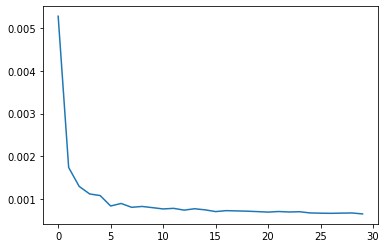

In [754]:
plt.plot(range(len(model.history.history['loss'])),model.history.history['loss'] )

### Step 5 - Evaluate on the Test Data

Evaluate on test data

so currently this network will see 20 history prices and predict the 21st price 
so we need the last 20 points of the training data to predict the first point of the test data

Let's test with the last 20 points in the train set and see what the model will predict

In [755]:
first_eval_batch = scaled_train[-20:]

In [756]:
#reshape to what the network expects
first_eval_batch = first_eval_batch.reshape((1,20,1))

In [757]:
first_eval_batch.shape

(1, 20, 1)

In [758]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 188ms/step


array([[0.630296]], dtype=float32)

Now lets predict for the entire test set

### Forecast Using the Model

In [759]:
# This will hold the predictions as we go along
test_predictions = []

#create the first evaluation batch with the last 20 inputs from the train set
#This will be used to predict the first value in the test set
first_eval_batch = scaled_train[-20:]

#reshape to what the RNN wants (same format as output of time series generator)
current_batch = first_eval_batch.reshape((1,20,1))

In [760]:
for i in range(len(test_set['Close'])):
    
    #Get the prediction one time step ahead of the past 20 points
    current_pred = model.predict(current_batch)[0]
    
    #store the prediction
    test_predictions.append(current_pred)
    
    #Update the current batch to include the prediction
    #you need to drop the first value from the current batch and add the prediction to the end
    #the indexing below is because the shape is 1,20,1.
    #x =1 , y = 20, z = 1
    #so we are grabbing the full sample ( x= 1), only from the 2nd up to the last of the y dimension
    # and then add the new prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis = 1)
    

1/1 [==============================] - 0s 22ms/step


In [761]:
test_predictions

[array([0.630296], dtype=float32),
 array([0.62816674], dtype=float32),
 array([0.6217693], dtype=float32),
 array([0.6152964], dtype=float32),
 array([0.60892576], dtype=float32),
 array([0.6026868], dtype=float32),
 array([0.59656405], dtype=float32),
 array([0.5905422], dtype=float32),
 array([0.584611], dtype=float32),
 array([0.57876396], dtype=float32),
 array([0.5729971], dtype=float32),
 array([0.56730866], dtype=float32),
 array([0.5616974], dtype=float32),
 array([0.5561633], dtype=float32),
 array([0.55070704], dtype=float32),
 array([0.54532886], dtype=float32),
 array([0.5400289], dtype=float32),
 array([0.5348065], dtype=float32),
 array([0.5296616], dtype=float32),
 array([0.5245945], dtype=float32),
 array([0.51960576], dtype=float32),
 array([0.5146953], dtype=float32),
 array([0.50986284], dtype=float32),
 array([0.50510836], dtype=float32),
 array([0.5004316], dtype=float32),
 array([0.4958325], dtype=float32),
 array([0.49131072], dtype=float32),
 array([0.48686606]

Note that the predictions are still scaled

### Step 5 - Transform predictions back to original data 

In [762]:
True_predictions = scaler.inverse_transform(test_predictions)

In [763]:
True_predictions

array([[0.77858878],
       [0.77828864],
       [0.77738685],
       [0.77647441],
       [0.77557639],
       [0.77469694],
       [0.77383386],
       [0.77298501],
       [0.77214894],
       [0.77132473],
       [0.77051182],
       [0.76970996],
       [0.76891899],
       [0.76813889],
       [0.76736977],
       [0.76661165],
       [0.76586456],
       [0.76512839],
       [0.76440316],
       [0.76368889],
       [0.76298567],
       [0.76229348],
       [0.76161229],
       [0.76094208],
       [0.76028284],
       [0.75963454],
       [0.75899714],
       [0.75837061],
       [0.75775492],
       [0.75715001],
       [0.75655582],
       [0.7559723 ],
       [0.75539938],
       [0.754837  ],
       [0.75428507],
       [0.75374354],
       [0.7532123 ],
       [0.7526913 ],
       [0.75218042],
       [0.75167957],
       [0.75118866],
       [0.75070761],
       [0.7502363 ],
       [0.74977462],
       [0.74932248],
       [0.74887976],
       [0.74844634],
       [0.748

Now I have the original values

In [764]:
original_test = test_set[['Close']]

In [765]:
original_test['predictions'] = True_predictions

### Step 6 - Evaluate RNN Performance

<AxesSubplot:xlabel='Date'>

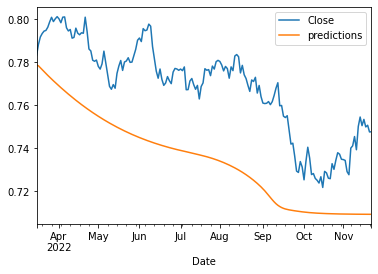

In [767]:
original_test.plot(legend=True)

In [768]:
mean_squared_error(original_test['Close'],original_test['predictions'],squared = False)

0.03507562465172962

In [ ]:
### Step 7 - Tuning Model - Improving Performance

So far, this RNN has given the highest RMSE. Why did it give such poor performance compared to the rest?
I will continue tweaking to see if there will be improvements 
so far I have changed sequence length from 5 to 20 and this caused the rmse to drop but still on (0.03963)
Try different timesteps & plot the results 

1. I'll try different timesteps values & compare performances

Epoch 1/25
1104/1104 [==============================] - 9s 7ms/step - loss: 0.0068
Epoch 2/25
1104/1104 [==============================] - 7s 6ms/step - loss: 0.0018
Epoch 3/25
1104/1104 [==============================] - 7s 7ms/step - loss: 0.0013
Epoch 4/25
1104/1104 [==============================] - 7s 7ms/step - loss: 0.0011
Epoch 5/25
1104/1104 [==============================] - 7s 7ms/step - loss: 0.0010
Epoch 6/25
1104/1104 [==============================] - 7s 7ms/step - loss: 9.3508e-04
Epoch 7/25
1104/1104 [==============================] - 7s 7ms/step - loss: 9.0222e-04
Epoch 8/25
1104/1104 [==============================] - 7s 7ms/step - loss: 8.1627e-04
Epoch 9/25
1104/1104 [==============================] - 7s 6ms/step - loss: 9.0808e-04
Epoch 10/25
1104/1104 [==============================] - 7s 7ms/step - loss: 8.4012e-04
Epoch 11/25
1104/1104 [==============================] - 7s 7ms/step - loss: 7.8424e-04
Epoch 12/25
1104/1104 [==============================] - 7s 6

1/1 [==============================] - 0s 25ms/step
Epoch 1/25
1084/1084 [==============================] - 18s 14ms/step - loss: 0.0101
Epoch 2/25
1084/1084 [==============================] - 14s 13ms/step - loss: 0.0020
Epoch 3/25
1084/1084 [==============================] - 15s 14ms/step - loss: 0.0015
Epoch 4/25
1084/1084 [==============================] - 14s 13ms/step - loss: 0.0013
Epoch 5/25
1084/1084 [==============================] - 13s 12ms/step - loss: 0.0011
Epoch 6/25
1084/1084 [==============================] - 13s 12ms/step - loss: 9.4848e-04
Epoch 7/25
1084/1084 [==============================] - 13s 12ms/step - loss: 9.0584e-04
Epoch 8/25
1084/1084 [==============================] - 14s 13ms/step - loss: 8.6227e-04
Epoch 9/25
1084/1084 [==============================] - 13s 12ms/step - loss: 8.2601e-04
Epoch 10/25
1084/1084 [==============================] - 13s 12ms/step - loss: 7.7634e-04
Epoch 11/25
1084/1084 [==============================] - 13s 12ms/step - loss

1/1 [==============================] - 0s 23ms/step
Epoch 1/25
1074/1074 [==============================] - 18s 15ms/step - loss: 0.0068
Epoch 2/25
1074/1074 [==============================] - 16s 15ms/step - loss: 0.0017
Epoch 3/25
1074/1074 [==============================] - 17s 15ms/step - loss: 0.0013
Epoch 4/25
1074/1074 [==============================] - 16s 15ms/step - loss: 0.0012
Epoch 5/25
1074/1074 [==============================] - 15s 14ms/step - loss: 0.0010
Epoch 6/25
1074/1074 [==============================] - 15s 14ms/step - loss: 9.4837e-04
Epoch 7/25
1074/1074 [==============================] - 16s 15ms/step - loss: 8.7465e-04
Epoch 8/25
1074/1074 [==============================] - 16s 15ms/step - loss: 8.3762e-04
Epoch 9/25
1074/1074 [==============================] - 16s 15ms/step - loss: 8.2851e-04
Epoch 10/25
1074/1074 [==============================] - 16s 15ms/step - loss: 7.6305e-04
Epoch 11/25
1074/1074 [==============================] - 15s 14ms/step - loss

1/1 [==============================] - 0s 56ms/step
Timestep 20 has an rmse of 0.017536682244544254.
Timestep 30 has an rmse of 0.018036320018463226.
Timestep 40 has an rmse of 0.019453517364745744.
Timestep 50 has an rmse of 0.027204263953219645.
Timestep 60 has an rmse of 113371312727710.56.


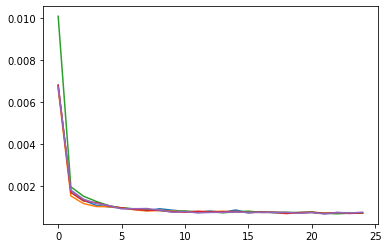

In [636]:
timesteps = [20,30,40,50,60]
rmse = []

for step in timesteps:
    train_generator = TimeseriesGenerator(scaled_train,scaled_train, length = step, batch_size=1)
    model2 = Sequential()
    model2.add(LSTM(150, activation='relu', input_shape=(step, 1)))
    model2.add(Dense(1)) #output prediction
    model2.compile(optimizer = 'adam', loss = 'mse')
    model2.fit(train_generator,epochs = 25)
    model2.history.history.keys()
    plt.plot(range(len(model2.history.history['loss'])),model2.history.history['loss'], label = f"Loss plot for Timestep:{step}")
    
    first_eval_batch2 = scaled_train[-step:]
    current_batch2 = first_eval_batch2.reshape((1,step,1))
    
    test_predictions2 = []
    
    for i in range(len(test_set['Close'])):
    
        current_pred2 = model2.predict(current_batch2)[0]
    
        #store the prediction
        test_predictions2.append(current_pred2)

        current_batch2 = np.append(current_batch2[:,1:,:],[[current_pred2]], axis = 1)
    
    predictions_true = scaler.inverse_transform(test_predictions2)
    
    original_test = test_set[['Close']]
    
    original_test['predictions'] = predictions_true
    
    
    rms = mean_squared_error(original_test['Close'],original_test['predictions'],squared = False)
    rmse.append(rms)
    
for i in range (len(rmse)):
    print(f'Timestep {timesteps[i]} has an rmse of {rmse[i]}.')

From the results above, we see that time steps of 20 gave the best results and the rmse is lower than that of the previous models. But even with the rmse, the model is still not able to predict the trends in the prices. Even if it cant get the exact price, its tsill not able to correctly predict whether there is an increase or decrease

3. I'll add another LSTM layer
Lets add an LSTM layer to see how ir performs(you can also add dropout if you fear there is overfitting)

Epoch 1/30
1104/1104 [==============================] - 16s 12ms/step - loss: 0.0059
Epoch 2/30
1104/1104 [==============================] - 13s 12ms/step - loss: 0.0023
Epoch 3/30
1104/1104 [==============================] - 13s 12ms/step - loss: 0.0017
Epoch 4/30
1104/1104 [==============================] - 13s 12ms/step - loss: 0.0014
Epoch 5/30
1104/1104 [==============================] - 13s 12ms/step - loss: 0.0012
Epoch 6/30
1104/1104 [==============================] - 14s 12ms/step - loss: 0.0011
Epoch 7/30
1104/1104 [==============================] - 13s 12ms/step - loss: 9.8755e-04
Epoch 8/30
1104/1104 [==============================] - 13s 12ms/step - loss: 9.7189e-04
Epoch 9/30
1104/1104 [==============================] - 13s 12ms/step - loss: 9.9939e-04
Epoch 10/30
1104/1104 [==============================] - 14s 12ms/step - loss: 9.6275e-04
Epoch 11/30
1104/1104 [==============================] - 13s 12ms/step - loss: 9.2973e-04
Epoch 12/30
1104/1104 [====================

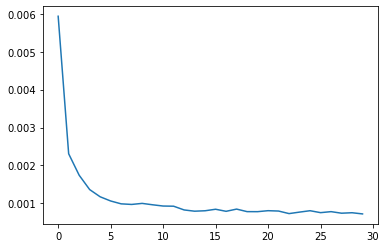

In [769]:
train_gen = TimeseriesGenerator(scaled_train,scaled_train, length = 20, batch_size=1)
stacked_model = Sequential()
stacked_model.add(LSTM(150, activation='relu', input_shape=(20, 1), return_sequences=True))
stacked_model.add(LSTM(150, activation='relu'))
stacked_model.add(Dense(1)) #output prediction
stacked_model.compile(optimizer = 'adam', loss = 'mse')
stacked_model.fit(train_gen,epochs = 30)
stacked_model.history.history.keys()
plt.plot(range(len(stacked_model.history.history['loss'])),stacked_model.history.history['loss'])

# This will hold the predictions as we go along
test_predictions = []

first_eval_batch = scaled_train[-20:]

current_batch = first_eval_batch.reshape((1,20,1))

for i in range(len(test_set['Close'])):
    
    current_pred = model.predict(current_batch)[0]

    test_predictions.append(current_pred)

    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis = 1)
    
True_predictions = scaler.inverse_transform(test_predictions)
    
original_test = test_set[['Close']]

original_test['predictions'] = True_predictions

<AxesSubplot:xlabel='Date'>

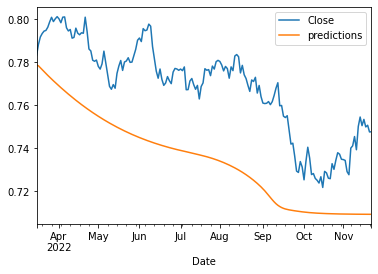

In [770]:
original_test.plot(legend=True)

In [771]:
mean_squared_error(original_test['Close'],original_test['predictions'],squared = False)

0.03507562465172962

**Even if it doesnt get the values, was it able to get the trend?**
   - This model has a higher RMSE than all the other models and also doesn't forecast the future trends properly

### Model 5 - Facebook Prophet

In [ ]:
print('head')

In [1]:
pip install prophet


  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730985 sha256=0a65211df33a18f826c9dd05cf9eecc35be0c612c1d2a0440ca8c8d7c80bf5ef
  Stored in directory: c:\users\olalawal\appdata\local\pip\cache\wheels\33\3d\82\4579e9cca41ff991140b2e050bc6df3a38292f26e4fa06b15d
Successfully built pymeeus


In [2]:
from prophet import Prophet

Prophet expects the data to be in a particular format.
- Date column needs to be called 'ds'
- Date col needs to be a pandas datetime object
- The target variable col needs to be called 'y'
- prophet expects daily data tho it can accept monthly


I'll clean the data to fit the format expected by Prophet

In [18]:
prices = pd.read_csv(r'C:\Users\olalawal\Downloads\CADUSD.csv', usecols = ['Date', 'Close'] )
prices

,Date,Close
0,2017-11-22,0.782840
1,2017-11-23,0.787092
2,2017-11-24,0.786621
3,2017-11-27,0.786535
4,2017-11-28,0.783797
...,...,...
1300,2022-11-16,0.753381
1301,2022-11-17,0.749878
1302,2022-11-18,0.750672
1303,2022-11-21,0.747557


Change the column names

In [19]:
prices.columns = ['ds','y']

In [20]:
prices

,ds,y
0,2017-11-22,0.782840
1,2017-11-23,0.787092
2,2017-11-24,0.786621
3,2017-11-27,0.786535
4,2017-11-28,0.783797
...,...,...
1300,2022-11-16,0.753381
1301,2022-11-17,0.749878
1302,2022-11-18,0.750672
1303,2022-11-21,0.747557


In [21]:
prices['ds'] = pd.to_datetime(prices['ds'])

### Train/Test Split

I'll split the data same way I split for the other the models.
Test set will have the last 9 months of data

In [64]:
train = prices[:1125]
test = prices[1125:]

Create the model

- Prophet automatically checks if there is any seasonality & uses what it finds but you can override it

In [68]:
model = Prophet()

Fit to the training data

In [69]:
model.fit(train)

23:10:08 - cmdstanpy - INFO - Chain [1] start processing
23:10:09 - cmdstanpy - INFO - Chain [1] done processing


Make the future dataframe 
- This will hold both the current dates (in the train set) + the dates for the next periods that you specify
- Since I want to predict 9 months (180 business days) into the future, I will use a period of 180

In [70]:
future = model.make_future_dataframe(periods = 180, freq='B')

In [71]:
forecast = model.predict(future)

<AxesSubplot:xlabel='ds'>

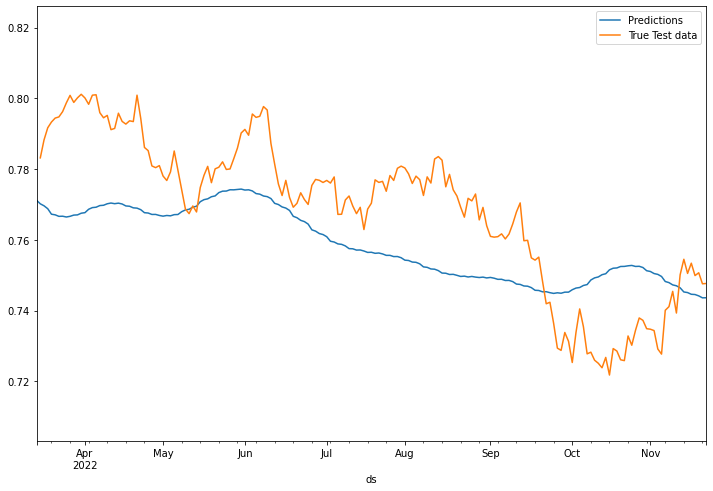

In [72]:
ax = forecast.plot(x='ds', y = 'yhat', label='Predictions', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label ='True Test data', legend=True, ax=ax, xlim = ('2022-03-15','2022-11-22'))

### Calculate RMSE 

In [73]:
from statsmodels.tools.eval_measures import rmse

In [74]:
predictions = forecast.iloc[-180:]['yhat']

In [75]:
predictions

1125    0.770164
1126    0.769607
1127    0.768783
1128    0.767233
1129    0.767053
          ...   
1300    0.744590
1301    0.744521
1302    0.744139
1303    0.743583
1304    0.743607
Name: yhat, Length: 180, dtype: float64

In [76]:
rmse(test['y'], predictions)

0.01863211618564846

**How did the Prophet Model Perform?**

- The prophet model gave the lowest RMSE I've seen so far.
- The plot also shows that the model is able to do a fair job of forecasting the future trend.
- It was able to forecast the downward trend around May, upward trend around june and even the drop seen around the end of november

#### Cross Validation

To confirm the performance, I'll do a bit of cross validation

In [77]:
#Perform cross validation on several sections

In [78]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [90]:
#initial training period - 2 years 

initial = 260 * 3
initial = str(initial) + 'days'

#Period length for cross val
period = 60
period = str(period) + 'days'

#horizon of prediction for each fold 
horizon = 180 #6 months
horizon = str(horizon) + 'days'

In [91]:
prices_cv = cross_validation(model, initial = initial , period=period, horizon = horizon)

  0%|          | 0/11 [00:00<?, ?it/s]

23:27:50 - cmdstanpy - INFO - Chain [1] start processing
23:27:51 - cmdstanpy - INFO - Chain [1] done processing
23:27:51 - cmdstanpy - INFO - Chain [1] start processing
23:27:51 - cmdstanpy - INFO - Chain [1] done processing
23:27:52 - cmdstanpy - INFO - Chain [1] start processing
23:27:52 - cmdstanpy - INFO - Chain [1] done processing
23:27:53 - cmdstanpy - INFO - Chain [1] start processing
23:27:53 - cmdstanpy - INFO - Chain [1] done processing
23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:54 - cmdstanpy - INFO - Chain [1] done processing
23:27:55 - cmdstanpy - INFO - Chain [1] start processing
23:27:55 - cmdstanpy - INFO - Chain [1] done processing
23:27:56 - cmdstanpy - INFO - Chain [1] start processing
23:27:57 - cmdstanpy - INFO - Chain [1] done processing
23:27:57 - cmdstanpy - INFO - Chain [1] start processing
23:27:57 - cmdstanpy - INFO - Chain [1] done processing
23:27:58 - cmdstanpy - INFO - Chain [1] start processing
23:27:59 - cmdstanpy - INFO - Chain [1]

In [92]:
performance_metrics(prices_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days,0.000137,0.011698,0.009280,0.012109,0.009632,0.012120,0.460993
1,19 days,0.000140,0.011847,0.009472,0.012365,0.010017,0.012386,0.443262
2,20 days,0.000139,0.011771,0.009430,0.012318,0.010085,0.012349,0.444782
3,21 days,0.000141,0.011865,0.009533,0.012453,0.010268,0.012495,0.443262
4,22 days,0.000144,0.012018,0.009711,0.012683,0.010465,0.012730,0.429472
...,...,...,...,...,...,...,...,...
158,176 days,0.003409,0.058391,0.046928,0.060060,0.063896,0.061749,0.725768
159,177 days,0.003486,0.059045,0.047575,0.060882,0.064931,0.062590,0.716312
160,178 days,0.003438,0.058631,0.047381,0.060588,0.064931,0.062244,0.720745
161,179 days,0.003358,0.057947,0.046997,0.060080,0.065636,0.061653,0.723404


C:\Users\olalawal\Anaconda3\lib\site-packages\prophet\plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\olalawal\Anaconda3\lib\site-packages\prophet\plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


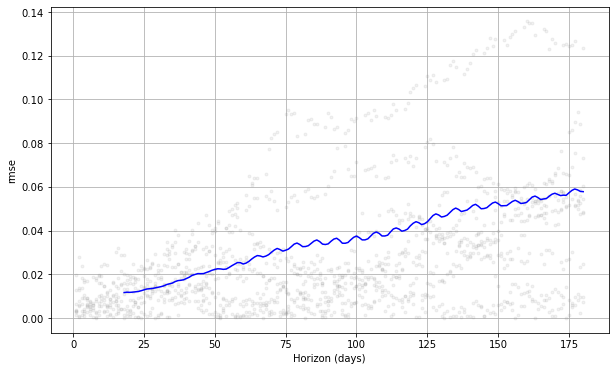

In [93]:
plot_cross_validation_metric(prices_cv, metric='rmse');

Even though, the RMSE from the cross validation is higher. I believe this is because less data is been used to train the model

## Final Recommendation

After implementing different models and comparing their performance on forecasting future trends & prices;
- Most of the models didnt perform well and this might be because of the sort of data we are dealing with.
- Can we really predict future exchange price based on just past prices. What happends to the external factors that actually affect this price?

Therefore, I recommend the following:
1. Do more research and obtain data that can be more suitable for this project
2. If the business can't obtain more data, The Prophet model can be deployed but bearing in mind its limitations 

## Next Steps

1. Deploy the Prophet Model